In [17]:
!pip install scikit-learn==1.5.2
!pip install "vegafusion[embed]>=1.5.0"
!pip install "vl-convert-python>=1.6.0"

In [18]:
import pandas as pd
import altair as alt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

alt.data_transformers.enable("vegafusion")

mini = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv')
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20000 non-null  int64  
 1   date           20000 non-null  object 
 2   bedrooms       20000 non-null  int64  
 3   bathrooms      20000 non-null  float64
 4   sqft_living    20000 non-null  int64  
 5   sqft_lot       20000 non-null  int64  
 6   floors         20000 non-null  float64
 7   waterfront     20000 non-null  int64  
 8   view           20000 non-null  int64  
 9   condition      20000 non-null  int64  
 10  grade          20000 non-null  int64  
 11  sqft_above     20000 non-null  int64  
 12  sqft_basement  20000 non-null  int64  
 13  yr_built       20000 non-null  int64  
 14  yr_renovated   20000 non-null  int64  
 15  zipcode        20000 non-null  int64  
 16  lat            20000 non-null  float64
 17  long           20000 non-null  float64
 18  sqft_l

In [19]:
school_lats = np.array([47.6436, 47.69, 47.7318, 47.62, 47.687879, 47.62861, 47.681208, 47.6135268, 47.620062, 47.6122319, 47.56806, 47.5589, 47.5573562, 47.66389, 47.6418378, 47.6045572, 47.6073792, 47.6253])
school_lons = np.array([-122.199, -122.07, -122.3274, -122.29, -122.300004, -122.03750, -122.065446, -122.3264696, -122.353688, -122.3160971, -122.17194, -122.1550, -122.2200904, -122.19111, -122.3169069, -122.1721639, -122.0256467, -122.0537])

In [20]:
def cleanData(df):
  # Bin house grade
  bins = {0, 3, 6, 7, 10, 13}
  labels = ["fail", "below average", "average", "above average", "highest quality"]

  df['quality'] = pd.cut(housing['grade'], bins=bins, labels=labels)


  # Get date of sale in year
  df['year_sold'] = df['date'].astype(str).str[:4].astype(int)
  # and month
  df['month_sold'] = df['date'].astype(str).str[4:6].astype(int)


  # Combine bedrooms & bathrooms
  df['bed_bath'] = df['bedrooms'] + df['bathrooms']


  # Quality per sq foot
  df['quality_sqft'] = df['sqft_living'] / df['grade']


  # Bin square footage, 500ft across
  bins = np.arange(df["sqft_living"].min(), df["sqft_living"].max() + 500, 500)
  df["sqft_bins"] = pd.cut(df["sqft_living"], bins=bins)


  # Normalize sqft_lot
  df["log_sqft_lot"] = np.log1p(df["sqft_lot"])


  # Transform yr_renovated to be useful
  # Treat 0 as missing
  df["yr_renovated"] = df["yr_renovated"].replace(0, np.nan)

  # Binary indicator
  df["was_renovated"] = df["yr_renovated"].notna().astype(int)

  # Numeric recency feature
  df["years_since_renovation"] = df["year_sold"] - df["yr_renovated"]


  # Cluster zip codes by like stats
  zip_stats = df.groupby("zipcode").agg({
      "sqft_lot" : ["mean", "median"],
      "sqft_living" : ["mean", "median"],
      "bedrooms" : ["mean", "median"],
      "bathrooms" : ["mean", "median"],
      "grade" : ["mean", "median"]
  })

  X_zip = StandardScaler().fit_transform(zip_stats)

  kmeans = KMeans(n_clusters=10)
  zip_stats["zip_cluster"] = kmeans.fit_predict(X_zip)
  zip_stats = zip_stats.round(2)
  zip_stats["zip_cluster"].value_counts()

  df['zip_cluster'] = df['zipcode'].map(zip_stats['zip_cluster'])


  # Check if house was resold
  df['resold'] = df['id'].duplicated(keep=False).astype(int)


  def in_range_columns(df, col1, col2, range_amount=150):
    return ((df[col1] - df[col2]).abs() <= range_amount).astype(int)

  # Check if house is similar to its neighbors in lot & living area
  df['similar_lot'] = in_range_columns(df, 'sqft_lot', 'sqft_lot15')
  df['similar_living'] = in_range_columns(df, 'sqft_living', 'sqft_living15')

  # Combine metrics to see if a house is likely to be an apartment
  df['likely_apartment'] = ((df['similar_lot'] == 1) & (df['similar_living'] == 1) & df['sqft_basement'] == 0).astype(int)


  # Distance to downtown Seattle

  # Coordinates of downtown Seattle
  downtown_lat = 47.6062
  downtown_lon = -122.3321

  def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c  # distance in km

  df['dist_downtown_km'] = haversine(df['lat'], df['long'], downtown_lat, downtown_lon)

  # Include log of distance to better handle non-linearity
  df['dist_downtown_km_log'] = np.log1p(df['dist_downtown_km'])


  # Distance to closest school

  def min_school_distance(row):
    return haversine(row['lat'], row['long'], school_lats, school_lons).min()

  df['dist_nearest_school_km'] = df.apply(min_school_distance, axis=1)


  # Spatial Bins

  # Bin size, about 1km
  lat_bin_size = 0.01
  lon_bin_size = 0.01

  # Create bins
  df['lat_bin1'] = (df['lat'] // lat_bin_size).astype(int)
  df['lon_bin1'] = (df['long'] // lon_bin_size).astype(int)

  # Combine bins
  df['grid_bin_1'] = df['lat_bin1'].astype(str) + "_" + df['lon_bin1'].astype(str)

  # Redo bins with 5km bins for more macro effects
  lat_bin_size = 0.05
  lon_bin_size = 0.05

  df['lat_bin5'] = (df['lat'] // lat_bin_size).astype(int)
  df['lon_bin5'] = (df['long'] // lon_bin_size).astype(int)

  df['grid_bin_5'] = df['lat_bin5'].astype(str) + "_" + df['lon_bin5'].astype(str)

  # Drop bin columns, not needed
  df = df.drop(columns=['lat_bin1', 'lon_bin1', 'lat_bin5', 'lon_bin5'])


  # Cluster features (unsupervised)
  features_to_cluster = ['lat', 'long']
  c = df[features_to_cluster]
  c_scaled = StandardScaler().fit_transform(c)

  kmeans = KMeans(n_clusters=10)
  df["house_cluster"] = kmeans.fit_predict(c_scaled)


  return df

In [21]:
mini = cleanData(mini)
housing = cleanData(housing)

In [22]:
features = ['dist_downtown_km', 'dist_downtown_km_log', 'dist_nearest_school_km',
            'grid_bin_1', 'grid_bin_5', 'grade', 'waterfront', 'sqft_bins', 'floors',
            'view', 'condition', 'was_renovated', 'years_since_renovation','zipcode',
            'zip_cluster', 'quality_sqft', 'quality', 'log_sqft_lot', 'resold',
            'likely_apartment', 'house_cluster']

categorical_cols = ['quality', 'zipcode', 'zip_cluster', 'sqft_bins', 'grid_bin_1', 'grid_bin_5', 'house_cluster']
numeric_cols = [c for c in features if c not in categorical_cols]

X = housing[features]
y = housing['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numeric_cols)
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [23]:
model = XGBRegressor(tree_method='approx', learning_rate=.025, n_estimators=3000, max_depth=10, subsample=0.8, colsample_bytree=0.6, min_child_weight=2, gamma=0, objective='reg:absoluteerror' )

model.fit(X_train_processed, y_train)
predictions = model.predict(X_test_processed)

result_rmse = root_mean_squared_error(y_test, predictions)
result_mae = mean_absolute_error(y_test, predictions)

print(result_rmse, result_mae)

121548.33575535814 64067.44781875


In [24]:
# mini_processed = preprocessor.transform(mini[features])
# team_predictions = model.predict(mini_processed)
# predictions_out = pd.DataFrame(np.round(team_predictions, 2), columns=['price'])
# predictions_out.to_csv("team2-module3-predictions.csv", index=False)

# 2/3 of predictions within 20% of original house price

In [25]:
model.score(X_test_processed, y_test)

0.8884870427347855

In [33]:
data = {
    "actual": y_test,
    "predicted": predictions
}

actual_vs_predicted = pd.DataFrame(data)

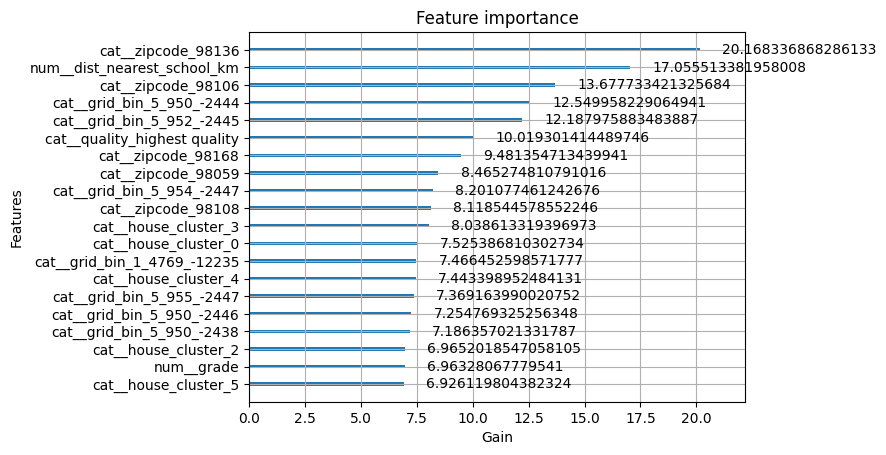

In [26]:
booster = model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

# Get the feature names after preprocessing from the ColumnTransformer
# This will include all one-hot encoded features as individual feature names
processed_feature_names = preprocessor.get_feature_names_out()

# Create a mapping from 'f{index}' (used by XGBoost) to the actual processed feature names
f_mapping = {f"f{i}": name for i, name in enumerate(processed_feature_names)}

# Sort importance_dict and use f_mapping to get the ordered feature names
# Use .get with a fallback to the key itself in case a feature name isn't found (though it should be now)
ordered_features_keys = [f for f, _ in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]]
ordered_features = [f_mapping.get(f, f) for f in ordered_features_keys]

ax = xgb.plot_importance(booster, importance_type='gain', xlabel='Gain', max_num_features=20)
# Set the y-axis labels using the correctly mapped feature names
ax.set_yticklabels(ordered_features)

plt.show()

In [61]:
base = alt.Chart(actual_vs_predicted).mark_circle(size=20, color='blue').encode(
    x=alt.X("actual:Q", title="Actual Price"),
    y=alt.Y("predicted:Q", title="Predicted Price"),
    tooltip=[alt.Tooltip("actual:Q", title="Actual Price"), alt.Tooltip("predicted:Q", title="Predicted Price")]
)
line = alt.Chart(actual_vs_predicted).mark_line(strokeDash=[5,5], color='red').encode(
    x=alt.X("actual:Q"),
    y=alt.Y("actual:Q")
)
upper20 = alt.Chart(actual_vs_predicted).mark_line(strokeDash=[5,5], color='green').transform_calculate(upper = 'datum.actual * 1.2').encode(
    x=alt.X("actual:Q"),
    y=alt.Y("upper:Q")
)
lower20 = alt.Chart(actual_vs_predicted).mark_line(strokeDash=[5,5], color='green').transform_calculate(lower = 'datum.actual * 0.8').encode(
    x=alt.X("actual:Q"),
    y=alt.Y("lower:Q")
)

(base + line + upper20 + lower20).properties(title="Actual Price vs Predicted Price")

alt.LayerChart(...)

In [27]:
alt.Chart(housing).mark_line(point=True).encode(
    x=alt.X("zipcode:N", sort="-y", title="ZIP Code"),
    y=alt.Y("mean(price):Q", title="Average Price"),
    tooltip=[
        alt.Tooltip("zipcode:N", title="ZIP Code "),
        alt.Tooltip("mean(price):Q", title="Avg Price")
    ]
)

alt.Chart(...)

In [32]:
alt.Chart(housing).mark_bar(point=True).encode(
  x=alt.X("price:Q", title="Price"),
  y=alt.Y("quality:O", title="quality"),
  tooltip=[alt.Tooltip("quality:Q", title="Quality"), alt.Tooltip("price:Q", title="Price")]
)

alt.Chart(...)

In [29]:
alt.Chart(housing).mark_line(point=True).encode(
    x=alt.X("price:Q", title="Price"),
    y=alt.Y("sqft_lot:Q", title="Lot Size"),
    tooltip=[alt.Tooltip("price:Q", title="Price"), alt.Tooltip("sqft_lot:Q", title="Square Footage of Lot")]
)

alt.Chart(...)

In [64]:
chart = alt.Chart(housing).mark_bar().encode(
    x=alt.X("dist_downtown_km:Q",
            bin=alt.Bin(step=10),  # 10 km bins
            title="Distance to Downtown Seattle"),
    y=alt.Y("mean(price):Q", title="Average Price"),
    tooltip=[
        alt.Tooltip("count()", title="Count of Houses"),
        alt.Tooltip("mean(price):Q", title="Average Price")
    ]
).properties(
    title="Average House Price by Distance to Downtown"
)

chart

alt.Chart(...)

In [67]:
chart = alt.Chart(housing).mark_bar().encode(
    x=alt.X("dist_nearest_school_km:Q",
            bin=alt.Bin(step=10),
            title="Distance to Nearest School"),
    y=alt.Y("mean(price):Q", title="Average Price"),
    tooltip=[
        alt.Tooltip("count()", title="Count of Houses"),
        alt.Tooltip("mean(price):Q", title="Average Price")
    ]
).properties(
    title="Average House Price by Distance to Nearest School"
)

chart

alt.Chart(...)

Ideas


1. Seasons
2. dist_downtown_km vs grade or sqft_living

feature transformation https://byui-cse.github.io/cse450-course/module-03/hints.html